# Indroduction
Text Classification Algorithm are at the heart of a variety of software systems that process text data at scale. Email software uses Text Classification to determine whether incomin email is sent to the inbox or filtered into the spam folder. Discussion forum use text classification to determine whether comments should be flagged as inappropiate.

These are two example of text classification, categorizing a text document into one of the predefined set of topics. In many topic classification problem, this categorization is based primarily on keywords in the texts.

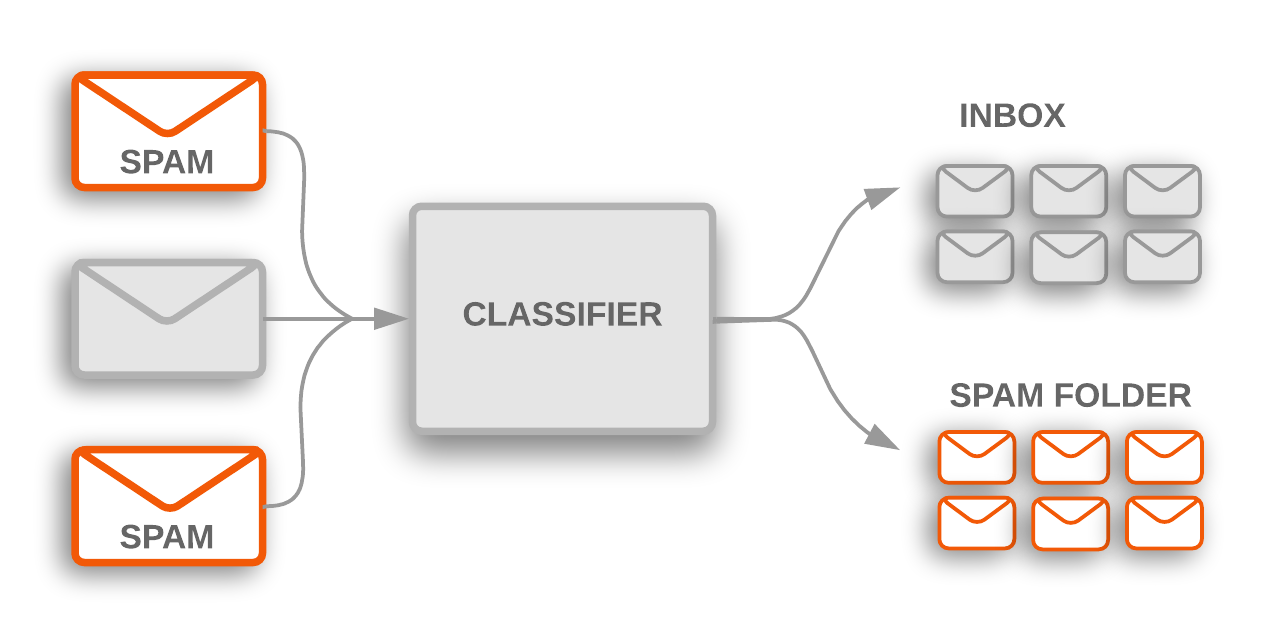

### Figure 1. Topic classification is used to flag incoming spam emails, which the filter into the spam folder.
Another type of text classification is sentiment analysis, whose goal is to identify the polarity of text content: the type of opinion it expresses. This can take the form of binary like/dislike rating, or a more granual set of options, such as star rating from 1 to 5. Example of sentiment analysis include analyzing twitter posts to determine if people liked the black panthor movie, or extrapolating the general public opinion of a new brand of nike shoes from walmart reviews.

This guide will teach you smoke key machine learning best practices for solving text classification problems.
1. The high level, end-to-end workflow for solving text classification problems using machine learning.
2. How to choose the right model for your text classification problem.
3. How to implement model of choice using TendorFlow.

## Text Classification Work Flow
 Here is a high level overview:
 * Step 1   - Gather Data
 * Step 2   - Explore your Data
 * Step 2.5 - Choose a Model
 * Step 3   - Prepare your Data
 * Step 4   - Bild, train and evaluate your model
 * Step 5   - Tune Hyperparameters
 * Step 6   - Deploy your Model
 
 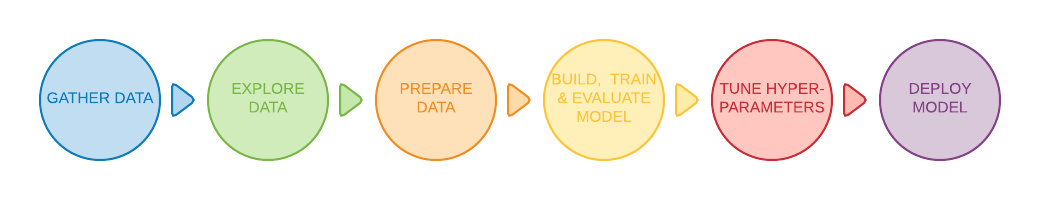
 
### Figure 2. Workflow for solving machine learning problems
 
# Step 1: Gather Data
Gathering data is the most important step in solving any supervised machine learning problem. Your text classifier can only be as good as the dataset it is built from.
If you don’t have a specific problem you want to solve and are just interested in exploring text classification in general, there are plenty of open source datasets available. You can find links to some of them in our GitHub repo. On the other hand, if you are tackling a specific problem, you will need to collect the necessary data. Many organizations provide public APIs for accessing their data—for example, the Twitter API or the NY Times API. You may be able to leverage these for the problem you are trying to solve.
Here are some important things to remember when collecting data:
If you are using a public API, understand the limitations of the API before using them. For example, some APIs set a limit on the rate at which you can make queries.
The more training examples (referred to as samples in the rest of this guide) you have, the better. This will help your model generalize better.
Make sure the number of samples for every class or topic is not overly imbalanced. That is, you should have comparable number of samples in each class.
Make sure that your samples adequately cover the space of possible inputs, not only the common cases.
Throughout this guide, we will use the Internet Movie Database (IMDb) movie reviews dataset to illustrate the workflow. This dataset contains movie reviews posted by people on the IMDb website, as well as the corresponding labels (“positive” or “negative”) indicating whether the reviewer liked the movie or not. This is a classic example of a sentiment analysis problem.

# Step 2: Explore your Data
Building and training a model is only one part of the workflow. Understanding the characteristics of your data beforehand will enable you to build a better model. This could simply mean obtaining a higher accuracy. It could also mean requiring less data for training, or fewer computational resources


# Uploading Data

In [ ]:
from pathlib import Path
import os
import random
import numpy as np

In [1]:

def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    imdb_data_path = os.path.join(data_path, 'aclImdb')
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname),encoding='utf-8') as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)    
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname), encoding='utf-8') as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)    
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)
    
    return((train_texts, np.array(train_labels)),
           (test_texts, np.array(test_labels)))




In [ ]:
a,b = load_imdb_sentiment_analysis_dataset('')

In [2]:
print(a[0][12])
print(a[1][12])

This is the start of a new and interesting Star Trek series. It has a "down to earth"-kind of feel with darker and less "plaggy" scenography.<br /><br />The characters need some more time to develop but they have potential. One thing that is fairly disappointing (with all Star Trek series really) is that they portray such a gloomy picture of the equality between men and women in the future when they paint a very positive picture about everything else. (Earth has stopped war, famine etc)<br /><br /> The female characters here are two, subcommander T'Pol who is vulcan and communications officer Hoshi who is human. Hoshi is quite wimpy and T'Pol is made to be a "vulcan babe".<br /><br /> Some of the crew attitudes feel a bit too American (as opposed to the more international feel of the TNG-crew) but creates interesting dynamics.<br /><br /> A very good pilot though for a very good series.
1


### Check the Data
After loading the data, it’s good practice to run some checks on it: pick a few samples and manually check if they are consistent with your expectations. For example, print a few random samples to see if the sentiment label corresponds to the sentiment of the review. Here is a review we picked at random from the IMDb dataset: “Ten minutes worth of story stretched out into the better part of two hours. When nothing of any significance had happened at the halfway point I should have left.” The expected sentiment (negative) matches the sample’s label.

Collect Key Metrics

Once you’ve verified the data, collect the following important metrics that can help characterize your text classification problem:

Number of samples: Total number of examples you have in the data.
Number of classes: Total number of topics or categories in the data.
Number of samples per class: Number of samples per class (topic/category). In a balanced dataset, all classes will have a 
                             similar number of samples; in an imbalanced dataset, the number of samples in each class will vary                              widely.
Number of words per sample: Median number of words in one sample.
Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.
Distribution of sample length: Distribution showing the number of words per sample in the dataset.

   

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__  import print_function

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_num_classes(labels):
    """ Get the number of classes
    Arguments:
    labels- list, label values.
             Thre should be atleast one sample of values in the
             range(0, num_classes-1)
    
    Returns:
      int, total number od classes.
    Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """  
    
    num_classes = max(labels+1)
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('missing smaples with label value(s)'
                         '{missing_classes}. Please make sure you have'
                         ' in the range(0, {max_class})'.format(
                          missing_classes = missing_classes, max_class = num_classes-1))
    
    if num_classes <= 1:
        raise ValueErroe('Invalid number of labels: {num_classes}.'
                         ' Please make sure their are aleast two classes'
                         'of samples'.format(num_classes=num_classes))
    return num_classes




    



    

In [4]:
get_num_classes(a[1])

2

In [6]:
def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

In [7]:
get_num_words_per_sample(a[0])

174.0

In [10]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
                                          
 
    # Create args required for vectorizing.
    
    kwargs = {'ngram_range':(1, 1),
              'dtype':'int32',
              'strip_accents':'unicode',
              'decode_error':'replace',
              'analyzer':'word'}
    vectorizer = CountVectorizer(**kwargs)
    
    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    
    vectorized_texts = vectorizer.fit_transform(sample_texts)
    
    # This is the list of all n-grams in the index order fromthe vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    

    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]
    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
                             zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]
    
    
    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel("N-grams")
    plt.ylabel("Frequencies")
    plt.title("Frequencies distribution of n-grams")
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

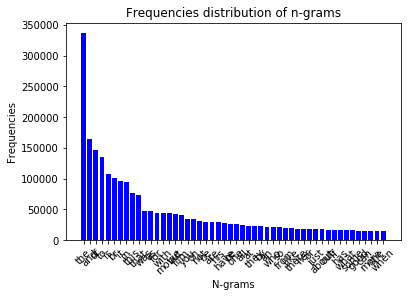

In [11]:
plot_frequency_distribution_of_ngrams(a[0])

In [12]:
def plot_sample_length_distribution(sample_texts):
   
               
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


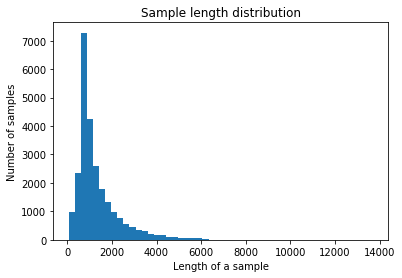

In [13]:
plot_sample_length_distribution(a[0])

In [14]:
def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()   

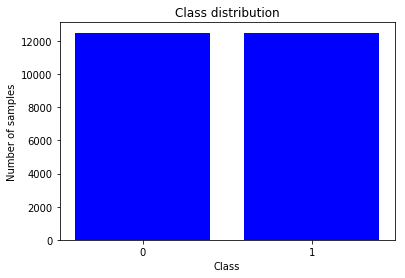

In [15]:
plot_class_distribution(a[1])

# Step 2.5 Choose a Model

At this point, we have assembled our dataset and gained insights into the key characteristics of our data. Next, based on the metrics we gathered in Step 2, we should think about which classification model we should use. This means/ asking questions such as, “How do we present the text data to an algorithm that expects numeric input?” (this is called data preprocessing and vectorization), “What type of model should we use?”, “What configuration parameters should we use for our model?”, etc.

Thanks to decades of research, we have access to a large array of data preprocessing and model configuration options. However, the availability of a very large array of viable options to choose from greatly increases the complexity and the scope of the particular problem at hand. Given that the best options might not be obvious, a naive solution would be to try every possible option exhaustively, pruning some choices through intuition. However, that would be tremendously expensive.

In this guide, we attempt to significantly simplify the process of selecting a text classification model. For a given dataset, our goal is to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training. We ran a large number (~450K) of experiments across problems of different types (especially sentiment analysis and topic classification problems), using 12 datasets, alternating for each dataset between different data preprocessing techniques and different model architectures. This helped us identify dataset parameters that influence optimal choices.

The model selection algorithm and flowchart below are a summary of our experimentation. Don’t worry if you don’t understand all the terms used in them yet; the following sections of this guide will explain them in depth.

In the flowchart below, the yellow boxes indicate data and model preparation processes. Grey boxes and green boxes indicate choices we considered for each process. Green boxes indicate our recommended choice for each process.

You can use this flowchart as a starting point to construct your first experiment, as it will give you good accuracy at low computation costs. You can then continue to improve on your initial model over the subsequent iterations.

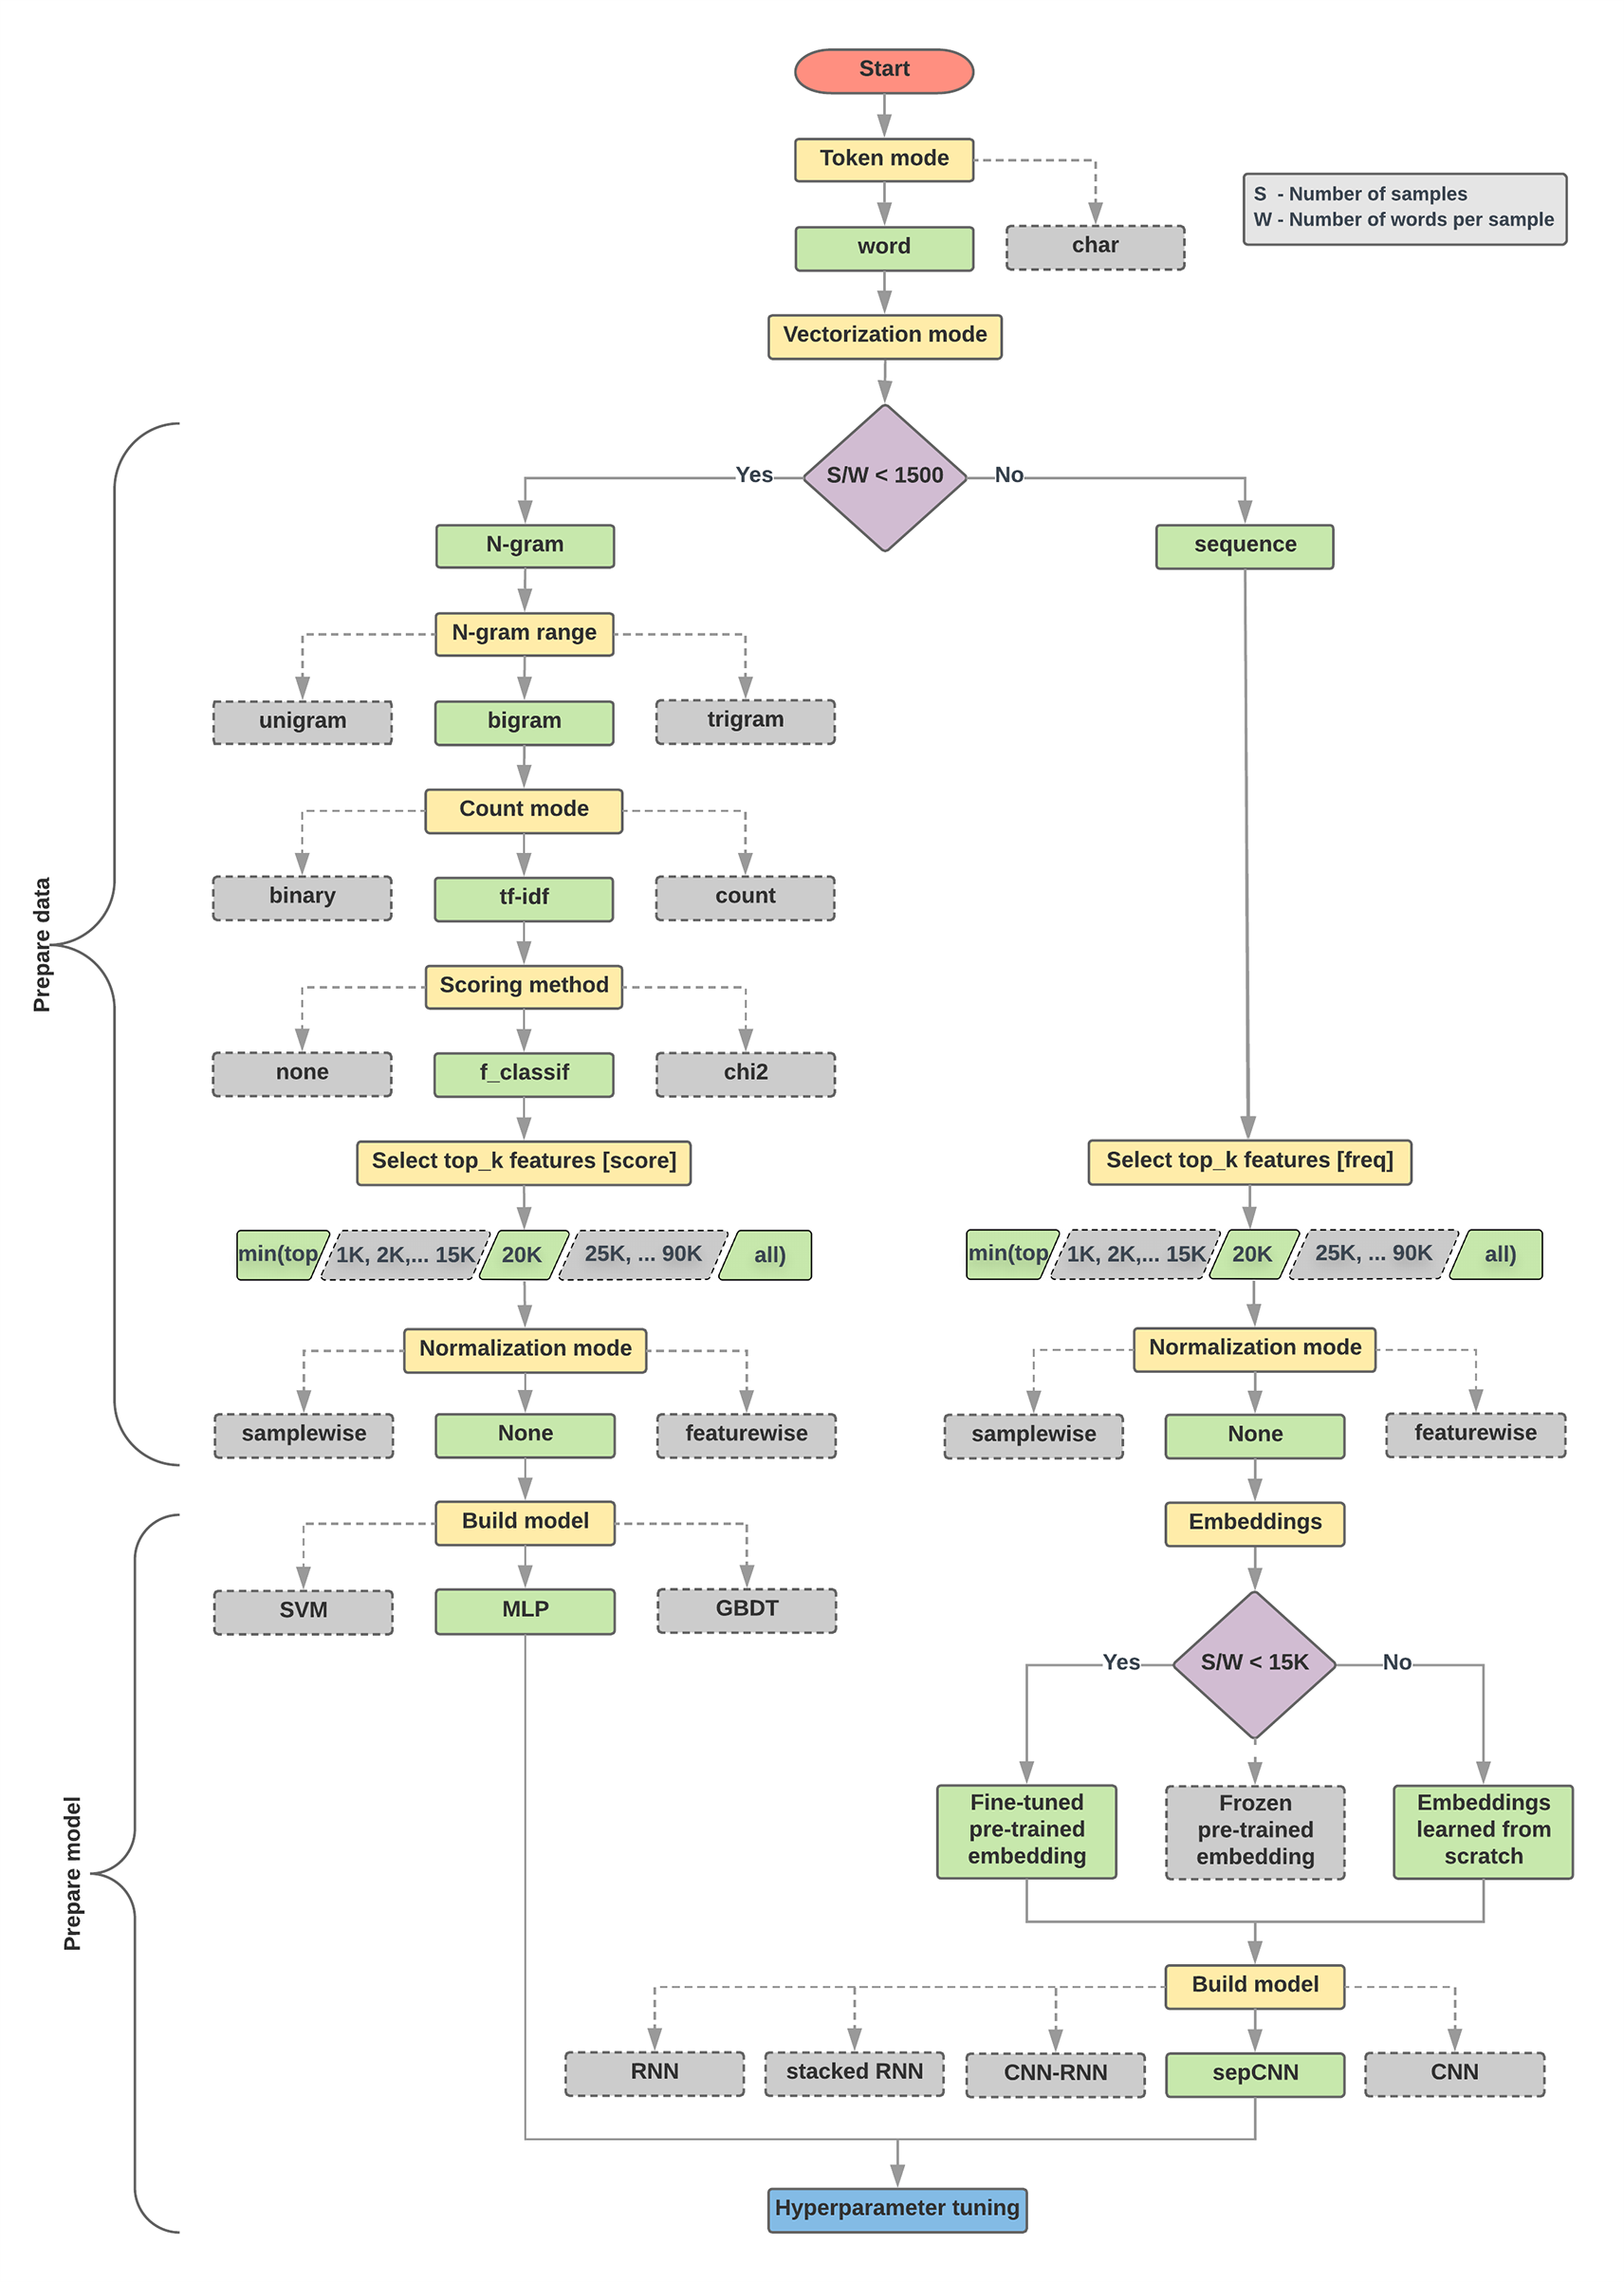

# Step 3: Prepare Your Data 

Before our data can be fed to a model, it needs to be transformed to a format the model can understand.

First, the data samples that we have gathered may be in a specific order. We do not want any information associated with the ordering of samples to influence the relationship between texts and labels. For example, if a dataset is sorted by class and is then split into training/validation sets, these sets will not be representative of the overall distribution of data.

A simple best practice to ensure the model is not affected by data order is to always shuffle the data before doing anything else. If your data is already split into training and validation sets, make sure to transform your validation data the same way you transform your training data. If you don’t already have separate training and validation sets, you can split the samples after shuffling; it’s typical to use 80% of the samples for training and 20% for validation.

Second, machine learning algorithms take numbers as inputs. This means that we will need to convert the texts into numerical vectors. There are two steps to this process:

Tokenization: Divide the texts into words or smaller sub-texts, which will enable good generalization of relationship between the texts and the labels. This determines the “vocabulary” of the dataset (set of unique tokens present in the data).

Vectorization: Define a good numerical measure to characterize these texts.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [27]:


#Vectorization paramater
#range(inclusive) of n gram sizes for tokensizing text
NGRAM_RANGE = (1,2)

#Limit on the number of feature. we use the top 20 k features.
TOP_K = 20000

#Whether text should be split into wards or character n-grams
# one of 'words', 'char'
TOKEN_MODE = 'word'
#minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """
    Vectorises text as ngram vector
    1 text = 1 tf-idf vector the length of vocabulory of unigrams + bigrams
    #ARGUMENTS:
    train_texts- list, training text string
    train_labels- np.ndarray, training labels
    val_texts- lists, validation text string
    
    #RETURNS:
      x_train, x_val : vectorization training and validation text
    """
    
    #Create keyword argument to pass to the 'tf-idf' vectorizer
    
    kwargs = {
        'ngram_range': NGRAM_RANGE,
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOCUMENT_FREQUENCY,
        
    }
    
    vectorizer = TfidfVectorizer(**kwargs)
    
     
    #Learn vocabulary from training texts and vectorize training texts
   
    x_train = vectorizer.fit_transform(train_texts)
    
    #Vectorize Validation texts
    
    x_val = vectorizer.transform(val_texts)
    
    #Select top 'k' of the vectorized feature.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transfrorm(x_val).astype('float32')
    return(x_train, x_val)
      
    
    
    
    

In [28]:
ngram_vectorize(a[0],a[1],a[0][12])   

ValueError: Iterable over raw text documents expected, string object received.

### N-gram vectors [Option A]
In the subsequent paragraphs, we will see how to do tokenization and vectorization for n-gram models. We will also cover how we can optimize the n- gram representation using feature selection and normalization techniques.

In an n-gram vector, text is represented as a collection of unique n-grams: groups of n adjacent tokens (typically, words). Consider the text The mouse ran up the clock. Here, the word unigrams (n = 1) are ['the', 'mouse', 'ran', 'up', 'clock'], the word bigrams (n = 2) are ['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock'], and so on.

Tokenization
We have found that tokenizing into word unigrams + bigrams provides good accuracy while taking less compute time.

Vectorization
Once we have split our text samples into n-grams, we need to turn these n-grams into numerical vectors that our machine learning models can process. The example below shows the indexes assigned to the unigrams and bigrams generated for two texts.

 Index assigned for every token: {'the': 7, 'mouse': 2, 'ran': 4, 'up': 10,
  'clock': 0, 'the mouse': 9, 'mouse ran': 3, 'ran up': 6, 'up the': 11, 'the
clock': 8, 'down': 1, 'ran down': 5}
Once indexes are assigned to the n-grams, we typically vectorize using one of the following options.

One-hot encoding: Every sample text is represented as a vector indicating the presence or absence of a token in the text.

'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Count encoding: Every sample text is represented as a vector indicating the count of a token in the text. Note that the element corresponding to the unigram 'the' (bolded below) now is represented as 2 because the word “the” appears twice in the text.

'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1]
Tf-idf encoding: The problem with the above two approaches is that common words that occur in similar frequencies in all documents (i.e., words that are not particularly unique to the text samples in the dataset) are not penalized. For example, words like “a” will occur very frequently in all texts. So a higher token count for “the” than for other more meaningful words is not very useful.

'The mouse ran up the clock' = [0.33, 0, 0.23, 0.23, 0.23, 0, 0.33, 0.47, 0.33,
0.23, 0.33, 0.33] (See Scikit-learn TdidfTransformer)
There are many other vector representations, but the above three are the most commonly used.

We observed that tf-idf encoding is marginally better than the other two in terms of accuracy (on average: 0.25-15% higher), and recommend using this method for vectorizing n-grams. However, keep in mind that it occupies more memory (as it uses floating-point representation) and takes more time to compute, especially for large datasets (can take twice as long in some cases).

Feature selection
When we convert all of the texts in a dataset into word uni+bigram tokens, we may end up with tens of thousands of tokens. Not all of these tokens/features contribute to label prediction. So we can drop certain tokens, for instance those that occur extremely rarely across the dataset. We can also measure feature importance (how much each token contributes to label predictions), and only include the most informative tokens.

There are many statistical functions that take features and the corresponding labels and output the feature importance score. Two commonly used functions are f_classif and chi2. Our experiments show that both of these functions perform equally well.

More importantly, we saw that accuracy peaks at around 20,000 features for many datasets. Adding more features over this threshold contributes very little and sometimes even leads to overfitting and degrades performance.




## Normalization
Normalization converts all feature/sample values to small and similar values. This simplifies gradient descent convergence in learning algorithms. From what we have seen, normalization during data preprocessing does not seem to add much value in text classification problems; we recommend skipping this step.

The following code puts together all of the above steps:

Tokenize text samples into word uni+bigrams,
Vectorize using tf-idf encoding,
Select only the top 20,000 features from the vector of tokens by discarding tokens that appear fewer than 2 times and using f_classif to calculate feature importance.

equence Vectors [Option B]
In the subsequent paragraphs, we will see how to do tokenization and vectorization for sequence models. We will also cover how we can optimize the sequence representation using feature selection and normalization techniques.

For some text samples, word order is critical to the text’s meaning. For example, the sentences, “I used to hate my commute. My new bike changed that completely” can be understood only when read in order. Models such as CNNs/RNNs can infer meaning from the order of words in a sample. For these models, we represent the text as a sequence of tokens, preserving order.

### Tokenization
Text can be represented as either a sequence of characters, or a sequence of words. We have found that using word-level representation provides better performance than character tokens. This is also the general norm that is followed by industry. Using character tokens makes sense only if texts have lots of typos, which isn’t normally the case.

### Vectorization
Once we have converted our text samples into sequences of words, we need to turn these sequences into numerical vectors. The example below shows the indexes assigned to the unigrams generated for two texts, and then the sequence of token indexes to which the first text is converted.

Texts: 'The mouse ran up the clock' and 'The mouse ran down'
Index assigned for every token: {'clock': 5, 'ran': 3, 'up': 4, 'down': 6, 'the': 1, 'mouse': 2}.
NOTE: 'the' occurs most frequently, so the index value of 1 is assigned to it.
Some libraries reserve index 0 for unknown tokens, as is the case here.
Sequence of token indexes: 'The mouse ran up the clock' = [1, 2, 3, 4, 1, 5]
There are two options available to vectorize the token sequences:

One-hot encoding: Sequences are represented using word vectors in n- dimensional space where n = size of vocabulary. This representation works great when we are tokenizing as characters, and the vocabulary is therefore small. When we are tokenizing as words, the vocabulary will usually have tens of thousands of tokens, making the one-hot vectors very sparse and inefficient. Example:

'The mouse ran up the clock' = [
  [0, 1, 0, 0, 0, 0, 0],
  [0, 0, 1, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0],
  [0, 0, 0, 0, 1, 0, 0],
  [0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 1, 0]
]

### Word embeddings: 
Words have meaning(s) associated with them. As a result, we can represent word tokens in a dense vector space (~few hundred real numbers), where the location and distance between words indicates how similar they are semantically (See Figure 7). This representation is called word embeddings.

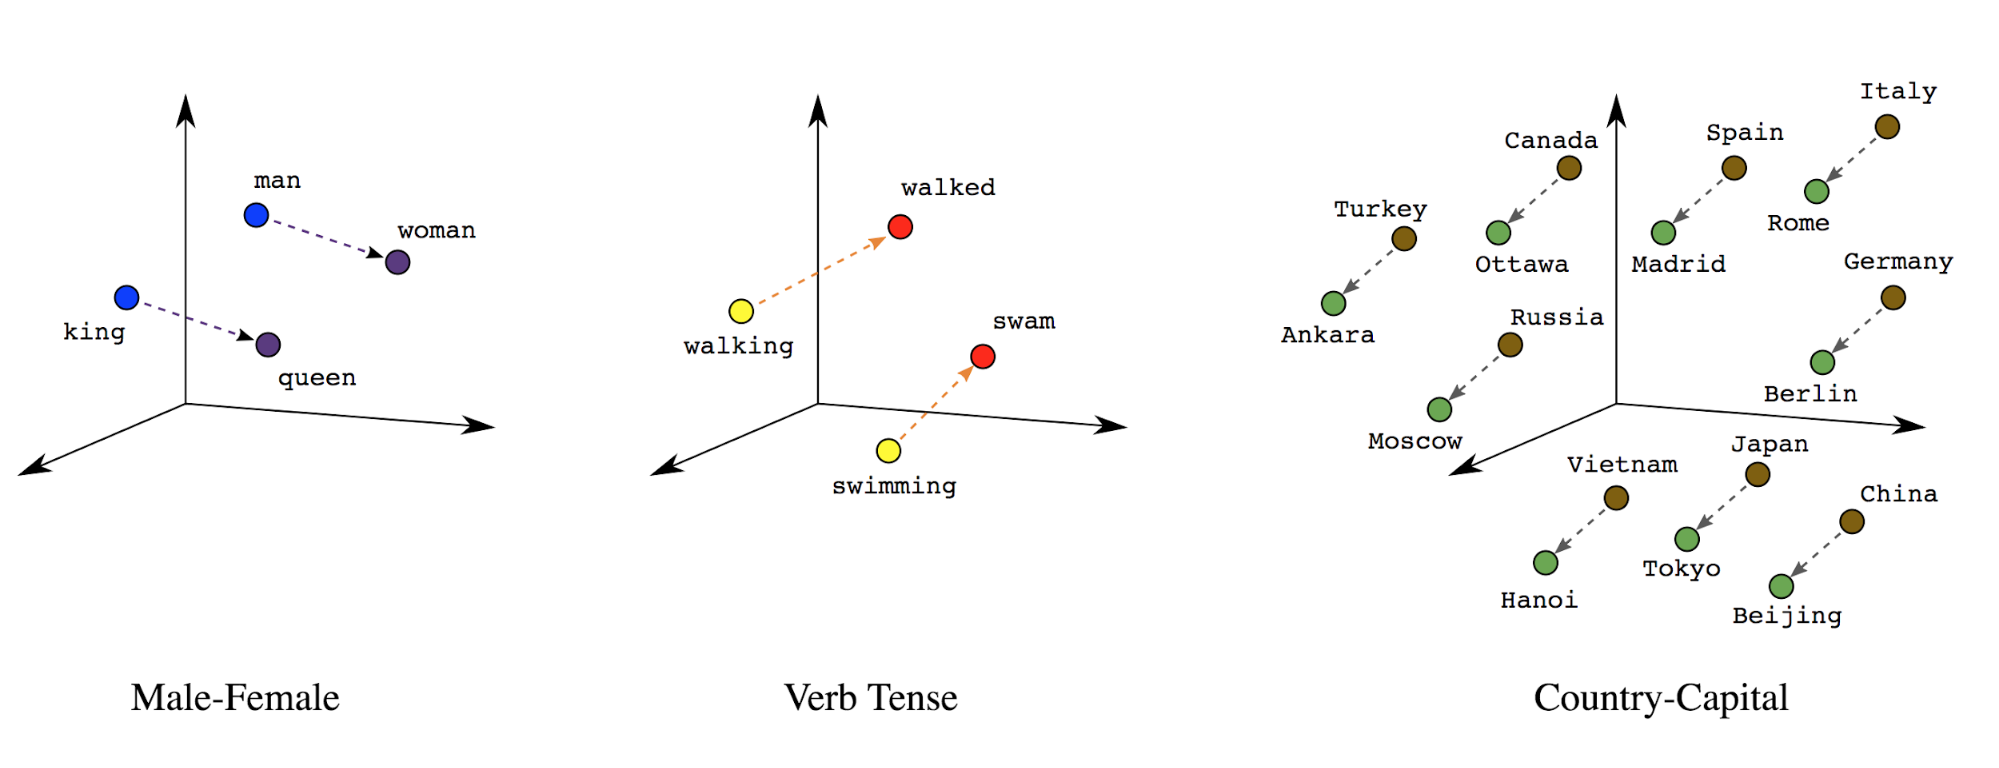

In [1]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:


# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """ 
    Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

### Label vectorization
We saw how to convert sample text data into numerical vectors. A similar process must be applied to the labels. We can simply convert labels into values in range [0, num_classes - 1]. For example, if there are 3 classes we can just use values 0, 1 and 2 to represent them. Internally, the network will use one-hot vectors to represent these values (to avoid inferring an incorrect relationship between labels). This representation depends on the loss function and the last- layer activation function we use in our neural network. We will learn more about these in the next section.

# Step 4: Build, Train, and Evaluate Your Model
In this section, we will work towards building, training and evaluating our model. In Step 3, we chose to use either an n-gram model or sequence model, using our S/W ratio. Now, it’s time to write our classification algorithm and train it. We will use TensorFlow with the tf.keras API for this.

Building machine learning models with Keras is all about assembling together layers, data-processing building blocks, much like we would assemble Lego bricks. These layers allow us to specify the sequence of transformations we want to perform on our input. As our learning algorithm takes in a single text input and outputs a single classification, we can create a linear stack of layers using the Sequential model API.
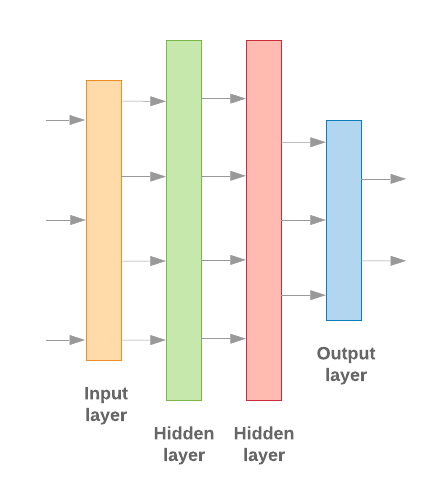


Step 4: Build, Train, and Evaluate Your Model
In this section, we will work towards building, training and evaluating our model. In Step 3, we chose to use either an n-gram model or sequence model, using our S/W ratio. Now, it’s time to write our classification algorithm and train it. We will use TensorFlow with the tf.keras API for this.

Building machine learning models with Keras is all about assembling together layers, data-processing building blocks, much like we would assemble Lego bricks. These layers allow us to specify the sequence of transformations we want to perform on our input. As our learning algorithm takes in a single text input and outputs a single classification, we can create a linear stack of layers using the Sequential model API.

Linear stack of layers

Figure 9: Linear stack of layers

The input layer and the intermediate layers will be constructed differently, depending on whether we’re building an n-gram or a sequence model. But irrespective of model type, the last layer will be the same for a given problem.

### Constructing the Last Layer
When we have only 2 classes (binary classification), our model should output a single probability score. For instance, outputting 0.2 for a given input sample means “20% confidence that this sample is in class 0, 80% that it is in class 1.” To output such a probability score, the activation function of the last layer should be a sigmoid function, and the loss function used to train the model should be binary cross-entropy (See Figure 10, left).

When there are more than 2 classes (multi-class classification), our model should output one probability score per class. The sum of these scores should be 1. For instance, outputting {0: 0.2, 1: 0.7, 2: 0.1} means “20% confidence that this sample is in class 0, 70% that it is in class 1, and 10% that it is in class 2.” To output these scores, the activation function of the last layer should be softmax, and the loss function used to train the model should be categorical cross-entropy. (See Figure 10, right).

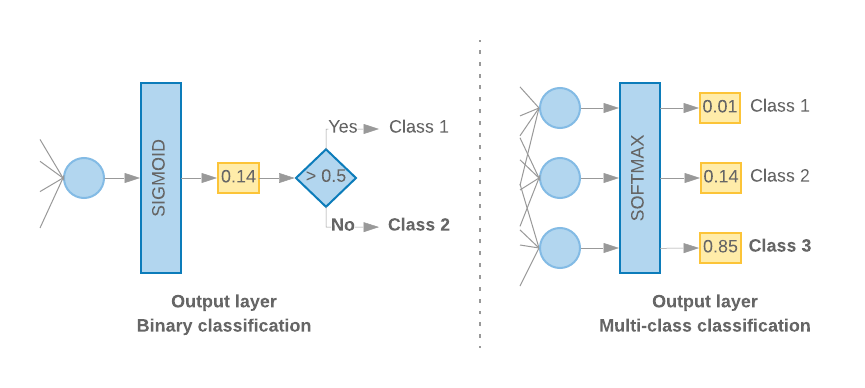
The following code defines a function that takes the number of classes as input, and outputs the appropriate number of layer units (1 unit for binary classification; otherwise 1 unit for each class) and the appropriate activation function:

In [23]:
def get_last_layer_units_and_activation(num_classes):
    """ Gets the #units and activation function for the last network layer
    # Arguments
        num_classes: int, number of classes
    # Return
        units, activation values
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return (units, activation)

        

In [24]:
get_last_layer_units_and_activation(23)

(23, 'softmax')

The following two sections walk through the creation of the remaining model layers for n-gram models and sequence models.
When the S/W ratio is small, we’ve found that n-gram models perform better than sequence models. Sequence models are better when there are a large number of small, dense vectors. This is because embedding relationships are learned in dense space, and this happens best over many samples.

## Build n-gram model [Option A]
We refer to models that process the tokens independently (not taking into account word order) as n-gram models. Simple multi-layer perceptrons (including logistic regression), gradient boosting machines and support vector machines models all fall under this category; they cannot leverage any information about text ordering.
We compared the performance of some of the n-gram models mentioned above and observed that multi-layer perceptrons (MLPs) typically perform better than other options. MLPs are simple to define and understand, provide good accuracy, and require relatively little computation.
The following code defines a two-layer MLP model in tf.keras, adding a couple of Dropout layers for regularization (to prevent overfitting to training samples).

In [25]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layer import Dropout

ModuleNotFoundError: No module named 'tensorflow'

In [29]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance od a multi layer perceptron model
    # Arguments
       layers: int, number of Dense layer in themodel
       units: int, output dimension of the layer
       dropout_rate: float, percentage of input to drop at Dropout  layer
       input_shape: tupel, shape of input to the model
       num_classes:int, number of output classes.
      
    # returns:
       An MLP model instance
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate = dropout_rate, input_shape=input_shape))
    
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=op_units, activation=op_activation))
    return (model)


In [ ]:
mlp_model()

# Build sequence model [Option B]

We refer to models that can learn from the adjacency of tokens as sequence models. This includes CNN and RNN classes of models. Data is pre-processed as sequence vectors for these models.

Sequence models generally have a larger number of parameters to learn. The first layer in these models is an embedding layer, which learns the relationship between the words in a dense vector space. Learning word relationships works best over many samples.

Words in a given dataset are most likely not unique to that dataset. We can thus learn the relationship between the words in our dataset using other dataset(s). To do so, we can transfer an embedding learned from another dataset into our embedding layer. These embeddings are referred to as pre-trained embeddings. Using a pre-trained embedding gives the model a head start in the learning process.

There are pre-trained embeddings available that have been trained using large corpora, such as GloVe. GloVe has been trained on multiple corpora (primarily Wikipedia). We tested training our sequence models using a version of GloVe embeddings and observed that if we froze the weights of the pre-trained embeddings and trained just the rest of the network, the models did not perform well. This could be because the context in which the embedding layer was trained might have been different from the context in which we were using it.

GloVe embeddings trained on Wikipedia data may not align with the language patterns in our IMDb dataset. The relationships inferred may need some updating—i.e., the embedding weights may need contextual tuning. We do this in two stages:

In the first run, with the embedding layer weights frozen, we allow the rest of the network to learn. At the end of this run, the model weights reach a state that is much better than their uninitialized values. For the second run, we allow the embedding layer to also learn, making fine adjustments to all weights in the network. We refer to this process as using a fine-tuned embedding.

Fine-tuned embeddings yield better accuracy. However, this comes at the expense of increased compute power required to train the network. Given a sufficient number of samples, we could do just as well learning an embedding from scratch. We observed that for S/W > 15K, starting from scratch effectively yields about the same accuracy as using fine-tuned embedding.

We compared different sequence models such as CNN, sepCNN (Depthwise Separable Convolutional Network), RNN (LSTM & GRU), CNN-RNN, and stacked RNN, varying the model architectures. We found that sepCNNs, a convolutional network variant that is often more data-efficient and compute-efficient, perform better than the other models.

Note: RNNs are relevant only to a small subset of use-cases. We did not try models like QRNN or RNNs with Attention, as their accuracy improvements would be offset by higher computational costs. 

The following code constructs a four-layer sepCNN model:

In [30]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializer
from tensorflow.python.keras import regularizer

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

ModuleNotFoundError: No module named 'tensorflow'

In [33]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
     """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

     # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    
    #add embedding layer. if pretrained embedding is used add weights to the
    #embedding layer and set trainable to the input is_embadding_trainable flag
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embadding_matrix],
                            trainable=is_embadding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))
    
    for _ in range(blocks-1 ):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return(model)
    
 

IndentationError: unindent does not match any outer indentation level (<ipython-input-33-fa6a26cd5c13>, line 32)


The actual training happens using the fit method. Depending on the size of your dataset, this is the method in which most compute cycles will be spent. In each training iteration, batch_size number of samples from your training data are used to compute the loss, and the weights are updated once, based on this value. The training process completes an epoch once the model has seen the entire training dataset. At the end of each epoch, we use the validation dataset to evaluate how well the model is learning. We repeat training using the dataset for a predetermined number of epochs. We may optimize this by stopping early, when the validation accuracy stabilizes between consecutive epochs, showing that the model is not training anymore.

### Table 3: Training hyperparameters

In [35]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    
    num_classes = explore_data.get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = vectorize_data.ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = build_model.mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

SyntaxError: invalid character in identifier (<ipython-input-35-f8fb3e6c9806>, line 2)